<a href="https://colab.research.google.com/github/AyushSingh331/Breast-Cancer-Prediction/blob/main/Breast_Cancer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,callbacks,mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_path="/content/drive/MyDrive/Breast Cancer/Breast Cancer Dataset/Original Dataset"

# Building A DataFrame

In [ ]:
data=[]

for folder_name,label in [("Non-Cancer",0),("Cancer",1)]:
  folder=os.path.join(data_path,folder_name)
  if not os.path.exists(folder):
    print(f"Folder {folder} does not exist")
    continue
  for img_name in os.listdir(folder):
    if img_name.lower().endswith(".jpg"):
      data.append({
          "filepath":os.path.join(folder,img_name),
          "label":label
      })

df=pd.DataFrame(data)
df=df.sample(frac=1,random_state=42).reset_index(drop=True)
df['label'] = df['label'].astype(str)
print(f"\nSuccessfully loaded {len(df)} real images")


Successfully loaded 745 real images


In [ ]:
print("Class distribution:")
print(df['label'].value_counts().sort_index())

Class distribution:
label
0    620
1    125
Name: count, dtype: int64


# Data Visualization

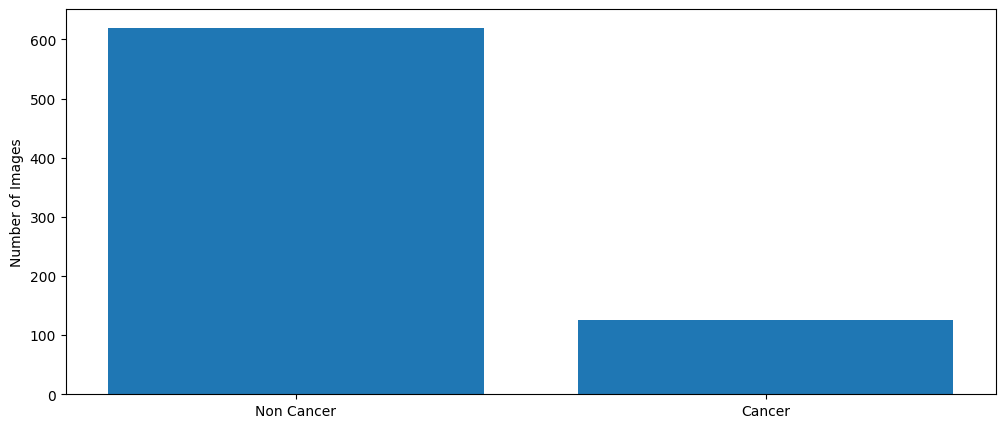

In [ ]:
fig,ax=plt.subplots(figsize=(12,5))
labels=['Non Cancer', 'Cancer']
counts=df['label'].value_counts().sort_index()
ax.bar(labels,counts)
ax.set_ylabel('Number of Images')
plt.show()

# Splitting the code into Training and Validation Set

In [ ]:
from sklearn.model_selection import train_test_split

train_df,val_df=train_test_split(df,test_size=0.2,stratify=df["label"],random_state=42)

# Converting the Images into a Fixed Size

In [ ]:
datagen=ImageDataGenerator(rescale=1./255)

train_gen=datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="sparse",
    shuffle=True
)

val_gen=datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="sparse",
    shuffle=True
)

Found 596 validated image filenames belonging to 2 classes.
Found 149 validated image filenames belonging to 2 classes.


# Data Augmentation

In [ ]:
activation=layers.LeakyReLU(negative_slope=0.1)

augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.4),
    layers.RandomTranslation(0.1, 0.1),
])

# Model Defining

In [ ]:
model=models.Sequential([
    layers.Input((224,224,3)),
    augmentation,

    layers.Conv2D(32,3,activation=activation,padding='same'),
    layers.MaxPooling2D(2,padding='same'),
    layers.Conv2D(64,3,activation=activation,padding='same'),
    layers.MaxPooling2D(2,padding='same'),
    layers.Conv2D(128,3,activation=activation,padding='same'),
    layers.MaxPooling2D(2,padding='same'),
    layers.Conv2D(256,3,activation=activation,padding='same'),
    layers.MaxPooling2D(2,padding='same'),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation=activation),
    layers.Dense(64,activation=activation),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax',dtype='float32')
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# CallBack

In [ ]:
callbacks_list=[
    callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=6,min_lr=1e-7),
    callbacks.EarlyStopping(monitor='val_accuracy',patience=15,restore_best_weights=True),
    callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/Breast Cancer/Models/original_model.keras',
        save_best_only=True,monitor='val_accuracy',verbose=1
    )
]

# Training the Model

In [ ]:
model_training=model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=callbacks_list
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7487 - loss: 0.5991
Epoch 1: val_accuracy improved from -inf to 0.83221, saving model to /content/drive/MyDrive/Breast Cancer/Models/original_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 681ms/step - accuracy: 0.7516 - loss: 0.5965 - val_accuracy: 0.8322 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8193 - loss: 0.5109
Epoch 2: val_accuracy did not improve from 0.83221
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 631ms/step - accuracy: 0.8199 - loss: 0.5096 - val_accuracy: 0.8322 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8376 - loss: 0.4704
Epoch 3: val_accuracy did not improve from 0.83221
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 584ms/step - accuracy: 0.8373 - loss: 0.4707 - val_accuracy: 0.8322 - val_loss: 0.4485 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8497 - los

# Model Visualization

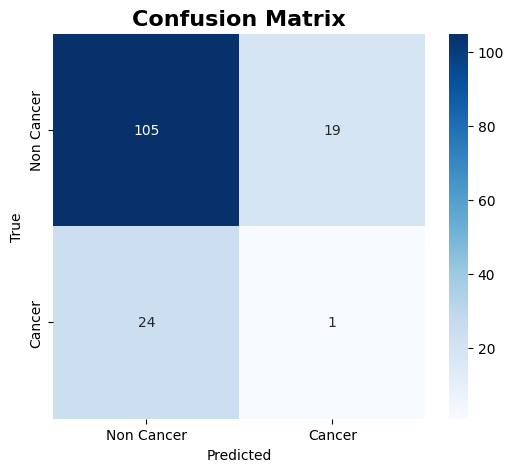

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

val_preds=model.predict(val_gen, verbose=0)
val_labels=val_gen.labels

if val_preds.shape[1]==1:
    val_preds_binary=(val_preds>0.5).astype(int).flatten()
else:
    val_preds_binary=np.argmax(val_preds,axis=1)

cm=confusion_matrix(val_labels,val_preds_binary)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Cancer', 'Cancer'],
            yticklabels=['Non Cancer', 'Cancer'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print(classification_report(val_labels,val_preds_binary,
                            target_names=['Non Cancer','Cancer'],digits=4))

              precision    recall  f1-score   support

  Non Cancer     0.8140    0.8468    0.8300       124
      Cancer     0.0500    0.0400    0.0444        25

    accuracy                         0.7114       149
   macro avg     0.4320    0.4434    0.4372       149
weighted avg     0.6858    0.7114    0.6982       149



# Using A Different Model

In [ ]:
df['label'] = df['label'].astype(float)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

datagen = ImageDataGenerator()

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(224,224), batch_size=32,
    class_mode='raw', shuffle=True)

val_gen = datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(224,224), batch_size=32,
    class_mode='raw', shuffle=False)

Found 596 validated image filenames.
Found 149 validated image filenames.


#Defining EfiicientNetB3

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

model = tf.keras.Sequential([
    layers.Input((224,224,3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.4),
    layers.Lambda(tf.keras.applications.efficientnet.preprocess_input),
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_5               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,785,072 (41.14 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

#Training the Model

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
        callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 974ms/step - accuracy: 0.6743 - loss: 0.6084 - val_accuracy: 0.8389 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 646ms/step - accuracy: 0.8293 - loss: 0.4059 - val_accuracy: 0.9060 - val_loss: 0.2822 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 653ms/step - accuracy: 0.8798 - loss: 0.3459 - val_accuracy: 0.9128 - val_loss: 0.2532 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 654ms/step - accuracy: 0.8954 - loss: 0.2954 - val_accuracy: 0.9195 - val_loss: 0.2362 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 644ms/step - accuracy: 0.8936 - loss: 0.2770 - val_accuracy: 0.9128 - val_loss: 0.2279 - learning_rate: 0.0010
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 638ms/step - accuracy: 0.9100 - loss: 0.2529 - val_accuracy: 0.9195 - val_loss: 0.2206 - learning_rate: 0.0010
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step - accuracy: 0.9212 - loss: 0.

#Saving the Model

In [ ]:
model.save('/content/drive/MyDrive/Breast Cancer/Models/imagenet_model.h5')

print("Model saved")

Model saved


#Evaluating the Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


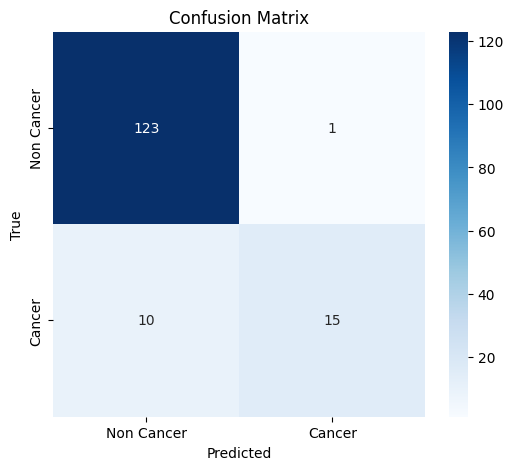

In [ ]:
from sklearn.metrics import confusion_matrix

val_preds=(model.predict(val_gen) > 0.5).astype(int).flatten()
val_true=val_gen.labels

cm=confusion_matrix(val_true, val_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=['Non Cancer','Cancer'],
            yticklabels=['Non Cancer','Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_true,val_preds,target_names=['Non Cancer','Cancer'],digits=4))

              precision    recall  f1-score   support

  Non Cancer     0.9248    0.9919    0.9572       124
      Cancer     0.9375    0.6000    0.7317        25

    accuracy                         0.9262       149
   macro avg     0.9312    0.7960    0.8445       149
weighted avg     0.9269    0.9262    0.9194       149



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

def load_model_safely(model_path):
    base=EfficientNetB3(weights='imagenet',include_top=False,input_shape=(224,224,3))
    base.trainable=False

    model=models.Sequential([
        layers.Input((224,224,3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.4),
        layers.Lambda(tf.keras.applications.efficientnet.preprocess_input),
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(1,activation='sigmoid')
    ])

    model.load_weights(model_path)

    print("Model loaded successfully using weights-only method!")
    return model

Model_path='/content/drive/MyDrive/Breast Cancer/Models/imagenet_model.keras'

model=load_model_safely(Model_path)

def predict_cancer():
    print("Upload a mammogram image")
    uploaded=files.upload()

    for fn in uploaded.keys():
        img=image.load_img(fn, target_size=(224, 224))
        x=image.img_to_array(img)
        x=np.expand_dims(x, axis=0)
        x=tf.keras.applications.efficientnet.preprocess_input(x.copy())

        pred=model.predict(x, verbose=0)[0][0]

        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.axis('off')

        if pred > 0.5:
            result="CANCER"
            conf=pred * 100
            color='red'
        else:
            result="NO CANCER"
            conf=(1-pred) * 100
            color='green'

        plt.title(f"{result}\nConfidence: {conf:.2f}%",color=color,fontsize=22,fontweight='bold')
        plt.show()

        print(f"RESULT → {result} ({conf:.2f}% confidence)")

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model loaded successfully using weights-only method!


Upload a mammogram image


Saving 8863_idx5_x151_y1301_class0.png to 8863_idx5_x151_y1301_class0.png


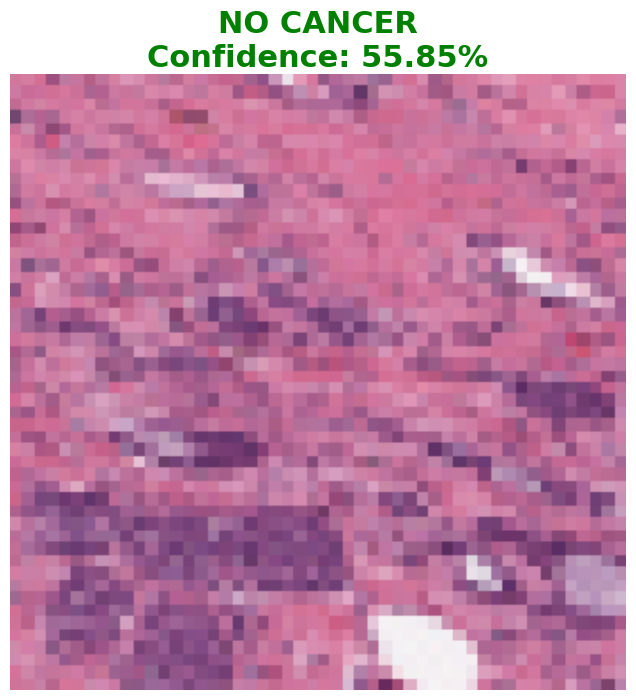

RESULT → NO CANCER (55.85% confidence)


In [ ]:
predict_cancer()